# About

Numerical plots pertaining to trials of a simplified 2-dim Kuramoto system with adaptive delays and no self-feedback links. Requires a folder of .mat files from the the following scripts:
 - script2D_iter.m

Uses the following packages and functions:

# Library

In [1]:
from __future__ import division, print_function

%matplotlib inline
# Toggle on/off
# %matplotlib notebook

import os
import numpy as np
import scipy.io as sio
from scipy import optimize
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.transforms as tsfm
import math
from math import pi

from lib import *

from IPython.display import clear_output

# Directories

In [2]:
# Data files (for fig.4d)
import_folder = 'matlab_fig4_4'
export_folder = 'export'
ex_name = 'process_fig4'

# Directory
dir_main = os.getcwd()
dir_im = os.path.join(dir_main, 'data2', import_folder)
dir_ex = os.path.join(dir_main, 'data2', export_folder)

filenames = os.listdir(dir_im)

# Import and compile data

## Constant parameters

In [3]:
dir_sam = os.path.join(dir_im, filenames[0])
dict_mat = sio.loadmat(dir_sam)

param = {'g': dict_mat['g'][0,0],
         'omega0': dict_mat['omega0'][0,0],
         'gain': dict_mat['gain'][0,0],
         'tf': dict_mat['tf'][0,0],
         'tau0': dict_mat['tau0'][0,0],
         }

# Asymptotic percentage
asy = 0.1

## Asymptotic values

In [4]:
# Compiled arrays
init_freqs = np.zeros(len(filenames))
init_Deltas = np.zeros(len(filenames))
asy_freqs = np.zeros(len(filenames))
asy_Deltas = np.zeros(len(filenames))
var_freqs = np.zeros(len(filenames))
BV_time = np.zeros(len(filenames)) # Time when Bounded Variation < tol

BV_tol = 0.005

# Choose two trials to use for figure D, in accordance to initial values
trial1_freq = 0.8
trial1_Delta0 = 0.4

trial2_freq = 1.4
trial2_Delta0 = 0.9

trial1_file = '' # purple
trial2_file = '' # orange

DIST1_MIN = 100
DIST2_MIN = 100

IND1 = 0
IND2 = 0

for i in range(len(filenames)):
    
    # Import .mat file
    dir_mat = os.path.join(dir_im, filenames[i])
    dict_mat = sio.loadmat(dir_mat)
    
    # Compile solution dictionary
    sol = {'t': np.reshape(dict_mat['t'], -1),
           'y': dict_mat['y'],
           'yp': dict_mat['yp'],
           'tau': dict_mat['tau'],
           'taup': dict_mat['taup']
          }
    
    init_freq = dict_mat['init_freq'][0,0]
    init_Delta = dict_mat['Delta0'][0,0]
    
    # Compute the global frequency:
    arr_omega = asylib.weight_avg(sol['t'], sol['yp'], asy)
    asy_Omega = np.sum(arr_omega) / arr_omega.size

    Omega_vars = asylib.weight_avg(sol['t'], (sol['yp'] - asy_Omega)**2, asy)
    Omega_var = np.sum(Omega_vars)

    # Get array of asymptotic phases:
    arr_lin = asy_Omega*sol['t']
    arr_lin = arr_lin[:,None]

    arr_phases = sol['y'] - arr_lin
    asy_phases = asylib.weight_avg(sol['t'], arr_phases, asy)

    # Variance
    phase_vars = asylib.weight_avg(sol['t'], (arr_phases - asy_phases)**2, asy)
    phase_var = np.sum(phase_vars)
    
    # Bounded variation
    BV_frac = 0.05
    t_int = BV_frac * param['tf']
    
    ind_s = np.argmin(sol['t'][sol['t'] > t_int])
    dev_arr1 = np.abs(sol['yp'][:, 0] - asy_Omega)
    dev_arr2 = np.abs(sol['yp'][:, 1] - asy_Omega)
    dev_arr = (dev_arr1 + dev_arr2) / 2
    
    ind_final = np.argmax(sol['t'] > param['tf'] - t_int)
    for j in range(ind_final):
        t_now = sol['t'][j]
        ind_f = np.argmax(sol['t'] > (t_now + t_int))
        BV = np.max(dev_arr[j:ind_f])
        if BV < BV_tol:
            BV_time[i] = sol['t'][j]
            break
        
    # SAVE TO ARRAYS
    init_freqs[i] = init_freq
    init_Deltas[i] = init_Delta
    asy_freqs[i] = asy_Omega
    asy_Deltas[i] = np.abs(asy_phases[1] - asy_phases[0])
    var_freqs[i] = Omega_var
    
    # Find .mat file name closest to either of the two selected trials
    DIST1 = np.sqrt((init_freq - trial1_freq)**2 + (init_Delta - trial1_Delta0)**2)
    DIST2 = np.sqrt((init_freq - trial2_freq)**2 + (init_Delta - trial2_Delta0)**2)
    
    if DIST1 < DIST1_MIN:
        DIST1_MIN = DIST1
        trial1_file = filenames[i]
        IND1 = i
    
    if DIST2 < DIST2_MIN:
        DIST2_MIN = DIST2
        trial2_file = filenames[i]
        IND2 = i
        
    # Print statements:
    # print("Trial: " + filenames[i] + ', asy.freq = ' + str(asy_Omega) + ', init.freq = ' + str(init_freq))

## Theoretical asy values

In [5]:
Omega_fun = lambda Omega: funlib.Omega2D(Omega, param)[0]
Delta_fun = lambda Omega: funlib.Omega2D(Omega, param)[1]

# Parameters
w0 = param['omega0']
g = param['g']
tau0 = param['tau0']

# Get all roots of Omega_fun in region
Omega_roots = rootlib.root_on_interval(Omega_fun, w0-g/2, w0+g/2, steps=500)
Delta_roots = np.zeros(Omega_roots.size)

for i in range(Omega_roots.size):
    Delta_roots[i] = Delta_fun(Omega_roots[i])

## Export

In [6]:
# Define export dictionary
ex_mat = {'eq_freqs': Omega_roots,
          'eq_Deltas': Delta_roots,
          'init_freqs': init_freqs,
          'init_Deltas': init_Deltas,
          'asy_freqs': asy_freqs,
          'asy_Deltas': asy_Deltas,
          'var_freqs': var_freqs,
          'g': param['g'],
          'w0': param['omega0'],
          'tau0': param['tau0']
          }

# Copy parameters
for par in param.keys():
    ex_mat[par] = param[par]

# Export to .mat (export folder)
dir_exfile = os.path.join(dir_ex, ex_name)
sio.savemat(dir_exfile, ex_mat)

# Arrays over time

Skip to this cell if asymptotic arrays have already been processed.

In [7]:
# Import from folder2 with at least two trials (converging to different frequencies
trial1 = {'color': 'purple', 'name': trial1_file}
trial2 = {'color': 'orangered', 'name': trial2_file}

### Trial 1

In [8]:
dir_mat1 = os.path.join(dir_im, trial1['name'])
dict_mat1 = sio.loadmat(dir_mat1, appendmat=False)

trial1['t'] = np.reshape(dict_mat1['t'], -1)
trial1['y'] = dict_mat1['y']
trial1['yp'] = dict_mat1['yp']
trial1['tau'] = dict_mat1['tau']
trial1['init_freq'] = dict_mat1['init_freq'][0,0]
trial1['Delta0'] = dict_mat1['Delta0'][0,0]

# Compute the asymptotic arrays
arr_omega1 = asylib.weight_avg(trial1['t'], trial1['yp'], asy)
asy_Omega1 = np.sum(arr_omega1) / arr_omega1.size


sol1 = {'t': np.reshape(dict_mat1['t'], -1),
       'y': dict_mat1['y'],
       'yp': dict_mat1['yp'],
       'tau': dict_mat1['tau'],
       'taup': dict_mat1['taup']
      }

# Get array of asymptotic phases:
arr_lin1 = asy_Omega1*sol1['t']
arr_lin1 = arr_lin1[:,None]

arr_phases1 = trial1['y'] - arr_lin1
asy_phases1 = asylib.weight_avg(trial1['t'], arr_phases1, asy)

# Store
trial1['phases'] = arr_phases1
trial1['asy_phases'] = asy_phases1
trial1['asy_Delta'] = np.abs(asy_phases1[1] - asy_phases1[0])
trial1['asy_Omega'] = asy_Omega1

### Trial 2

In [9]:
dir_mat2 = os.path.join(dir_im, trial2['name'])
dict_mat2 = sio.loadmat(dir_mat2)

trial2['t'] = np.reshape(dict_mat2['t'], -1)
trial2['y'] = dict_mat2['y']
trial2['yp'] = dict_mat2['yp']
trial2['tau'] = dict_mat2['tau']
trial2['init_freq'] = dict_mat2['init_freq'][0,0]
trial2['Delta0'] = dict_mat2['Delta0'][0,0]

# Compute the asymptotic arrays
arr_omega2 = asylib.weight_avg(trial2['t'], trial2['yp'], asy)
asy_Omega2 = np.sum(arr_omega2) / arr_omega2.size


sol2 = {'t': np.reshape(dict_mat2['t'], -1),
       'y': dict_mat2['y'],
       'yp': dict_mat2['yp'],
       'tau': dict_mat2['tau'],
       'taup': dict_mat2['taup']
      }

# Get array of asymptotic phases:
arr_lin2 = asy_Omega2*sol2['t']
arr_lin2 = arr_lin2[:,None]

arr_phases2 = trial2['y'] - arr_lin2
asy_phases2 = asylib.weight_avg(trial2['t'], arr_phases2, asy)

# Store
trial2['phases'] = arr_phases2
trial2['asy_phases'] = asy_phases2
trial2['asy_Delta'] = np.abs(asy_phases2[1] - asy_phases2[0])
trial2['asy_Omega'] = asy_Omega2

# Asymptotic arrays

In [10]:
# Import arrays and values
dir_exfile = os.path.join(dir_ex, ex_name)
dict_ex = sio.loadmat(dir_exfile)

eq_freqs = np.reshape(dict_ex['eq_freqs'], -1)
eq_Deltas = np.reshape(dict_ex['eq_Deltas'], -1)
init_freqs = np.reshape(dict_ex['init_freqs'], -1)
init_Deltas = np.reshape(dict_ex['init_Deltas'], -1)
asy_freqs = np.reshape(dict_ex['asy_freqs'], -1)
asy_Deltas = np.reshape(dict_ex['asy_Deltas'], -1)

# Create mesh for colour map

tol = 0.1

# Cluster asy_freqs
conv_freqs = np.array([asy_freqs[0]])
asy_convs = np.array([0])
maxerr_convs = np.array([0.])

for j in range(1,asy_freqs.size):
    ind_conv = np.argmin(np.abs(asy_freqs[j] - conv_freqs))
    err_conv = np.min(np.abs(asy_freqs[j] - conv_freqs))
    
    if err_conv < tol:
        asy_convs = np.append(asy_convs, ind_conv)
        maxerr_convs[ind_conv] = np.max((maxerr_convs[ind_conv], err_conv))
        
    else:
        conv_freqs = np.append(conv_freqs, asy_freqs[j])
        asy_convs = np.append(asy_convs, conv_freqs.size-1)
        maxerr_convs = np.append(maxerr_convs, 0.)
        
freq_arr = np.unique(init_freqs)
Delta_arr = np.unique(init_Deltas)

freq_mesh, Delta_mesh = np.meshgrid(freq_arr, Delta_arr)
c_mesh = np.zeros(freq_mesh.shape)
c_mesh_scale = np.zeros(freq_mesh.shape)

for i in range(init_freqs.size):
    # First index Delta, second index freq
    ind1 = np.argmin(np.abs(Delta_arr - init_Deltas[i]))
    ind2 = np.argmin(np.abs(freq_arr - init_freqs[i]))
    
    # Convergence frequency
    c_mesh[ind1, ind2] = asy_convs[i]
    c_mesh_scale[ind1, ind2] = 1 - (BV_time[i] / np.max(BV_time))

# Convert to sign
c_mesh_graph = 1 - c_mesh
# c_mesh_sign = 1 - 2*c_mesh
# c_mesh_graph = 0.5 + 0.5 * c_mesh_sign * c_mesh_scale

# Plot

## Options

In [11]:
# Plot positions [left, bottom, width, height] 
bbox0 = [0.15, 0.7, 0.35, 0.20]  # Fig 2a: Derivative plots
bbox1 = [0.15, 0.4, 0.35, 0.20]  # Fig 2b: sin(phase) plots
bbox2 = [0.15, 0.1, 0.35, 0.20] # Fig 2c: Delay plots
bbox3 = [0.60, 0.1, 0.45, 0.8] # Fig 2d: Iterated trial plot

# Figure a,b,c lines
line_opts = {'linewidth': 1.8,
             'alpha': 0.9
            }

ls1 = (0, (5,1))
ls2_1 = (0, (1,3))
ls2_2 = (2, (1,3))

tf = np.max(trial1['t'])

# Dotted lines (linking initial to asy points in fig.d)
dotopts = {'linestyle': '-',
           'linewidth': 0.9,
           'marker': None,
           'alpha': 1.0
          }

omega_opts = {'linewidth': 1.2,
              'linestyle': 'solid',
              'alpha': 0.8,
              'color': 'green'
              }


num_plot = int(init_freqs.size)
freq_absmax = np.max(np.abs(init_freqs - dict_ex['w0']))

alpha = 0.5
levels = np.linspace(0, 1, 4, endpoint=True)

## Generate figure

(0.0, 80.0)

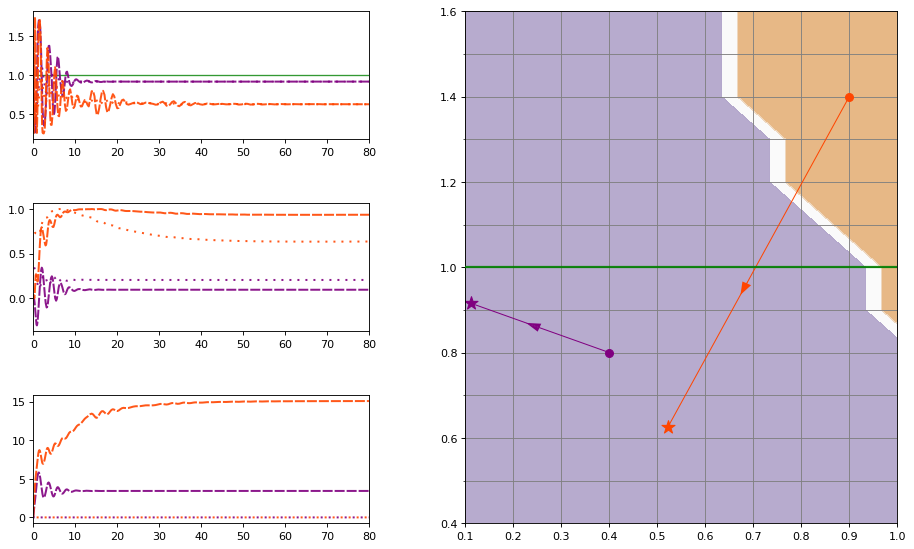

In [12]:
fig, ax = plt.subplots(4, figsize=(12,8), dpi=80)

# Set positions
ax[0].set_position(bbox0)
ax[1].set_position(bbox1)
ax[2].set_position(bbox2)
ax[3].set_position(bbox3)

# Trial 1:
ax[0].plot(trial1['t'], trial1['yp'][:,0], color=trial1['color'], linestyle=ls1, **line_opts)
ax[1].plot(trial1['t'], np.sin(trial1['phases'])[:,0], color=trial1['color'], linestyle=ls1, **line_opts)
ax[2].plot(trial1['t'], trial1['tau'][:,0], color=trial1['color'], linestyle=ls1, **line_opts)

ax[0].plot(trial1['t'], trial1['yp'][:,1], color=trial1['color'], linestyle=ls2_1, **line_opts)
ax[1].plot(trial1['t'], np.sin(trial1['phases'])[:,1], color=trial1['color'], linestyle=ls2_2, **line_opts)
ax[2].plot(trial1['t'], trial1['tau'][:,1], color=trial1['color'], linestyle=ls2_1, **line_opts)

# Trial 2:
ax[0].plot(trial2['t'], trial2['yp'][:,0], color=trial2['color'], linestyle=ls1, **line_opts)
ax[1].plot(trial2['t'], np.sin(trial2['phases'])[:,0], color=trial2['color'], linestyle=ls1, **line_opts)
ax[2].plot(trial2['t'], trial2['tau'][:,0], color=trial2['color'], linestyle=ls1, **line_opts)

ax[0].plot(trial2['t'], trial2['yp'][:,1], color=trial2['color'], linestyle=ls2_2, **line_opts)
ax[1].plot(trial2['t'], np.sin(trial2['phases'])[:,1], color=trial2['color'], linestyle=ls2_2, **line_opts)
ax[2].plot(trial2['t'], trial2['tau'][:,1], color=trial2['color'], linestyle=ls2_2, **line_opts)

ax[0].axhline(y=dict_ex['w0'], zorder=-1, **omega_opts)

# Figure D (colour map):
c = ax[3].contourf(Delta_mesh, freq_mesh, c_mesh_graph, levels, cmap='PuOr', alpha=alpha)
ax[3].set_yticks(freq_arr, minor=True)
ax[3].set_xticks(Delta_arr, minor=True)
ax[3].grid(b=True, which='minor', color='grey', zorder=-1)
    
# ax[3].scatter(init_Deltas[:num_plot], init_freqs[:num_plot], color='orange', zorder=-1)
# ax[3].scatter(asy_Deltas[:num_plot], asy_freqs[:num_plot], color='magenta', zorder=1)
# ax[3].scatter(eq_Deltas, eq_freqs, color='blue', zorder=2)

# Trials, init
ax[3].scatter(trial1['Delta0'], trial1['init_freq'], color=trial1['color'], s=50, zorder=2)
ax[3].scatter(trial2['Delta0'], trial2['init_freq'], color=trial2['color'], s=50, zorder=2)

# Trials, asy
ax[3].scatter(trial1['asy_Delta'], trial1['asy_Omega'], color=trial1['color'], s=150, marker='*', zorder=2)
ax[3].scatter(trial2['asy_Delta'], trial2['asy_Omega'], color=trial2['color'], s=150, marker='*', zorder=2)

# Lines
p1 = np.array([trial1['Delta0'], trial1['asy_Delta']])
p2 = np.array([trial1['init_freq'], trial1['asy_Omega']])
p3 = np.array([trial2['Delta0'], trial2['asy_Delta']])
p4 = np.array([trial2['init_freq'], trial2['asy_Omega']])

ax[3].plot(p1, p2, **dotopts, color=trial1['color'], zorder=2)
ax[3].plot(p3, p4, **dotopts, color=trial2['color'], zorder=2)

# Arrows
POS1_x = lambda t: trial1['Delta0'] * t + trial1['asy_Delta'] * (1 - t)
POS1_y = lambda t: trial1['init_freq'] * t + trial1['asy_Omega'] * (1 - t)

POS2_x = lambda t: trial2['Delta0'] * t + trial2['asy_Delta'] * (1 - t)
POS2_y = lambda t: trial2['init_freq'] * t + trial2['asy_Omega'] * (1 - t)

P1x_1 = POS1_x(0.44)
P1x_2 = POS1_x(0.40)
P1y_1 = POS1_y(0.44)
P1y_2 = POS1_y(0.40)

P2x_1 = POS2_x(0.44)
P2x_2 = POS2_x(0.40)
P2y_1 = POS2_y(0.44)
P2y_2 = POS2_y(0.40)

ax[3].arrow(P1x_1, P1y_1, P1x_2 - P1x_1, P1y_2 - P1y_1, 
            shape='full', lw=0, length_includes_head=True, 
            head_width=.02, color=trial1['color'], zorder=3)

ax[3].arrow(P2x_1, P2y_1, P2x_2 - P2x_1, P2y_2 - P2y_1, 
            shape='full', lw=0, length_includes_head=True, 
            head_width=.02, color=trial2['color'], zorder=3)

# Extra lines
ax[3].axhline(y=dict_ex['w0'], color='green', alpha=0.9, linewidth=2.0, zorder=3)
ax[3].axvline(x=0, color='black', alpha=0.5, linewidth=0.5, zorder=3)

# Graph bounds
ax[3].set_ylim(bottom=np.min(init_freqs), top=np.max(init_freqs))
ax[3].set_xlim(left=np.min(init_Deltas), right=np.max(init_Deltas))

# ax[3].set_xlim(left= -0.2*np.max(init_Deltas), right=1.2*np.max(init_Deltas))
# ax[3].set_ylim(bottom=dict_ex['w0'] - 1.1*freq_absmax, top=dict_ex['w0'] + 1.1*freq_absmax)

# Adjustments to axes
ax[0].set_xlim(left=np.min(trial1['t']), right=tf)
ax[1].set_xlim(left=np.min(trial1['t']), right=tf)
ax[2].set_xlim(left=np.min(trial1['t']), right=tf)

# Additional lines
# ax[3].axhline(y=eq_freqs[0], xmax=0.48, color = 'blue', ls='dashed', zorder=-2)
# ax[3].axhline(y=eq_freqs[1], xmax=0.35, color = 'blue', ls='dashed', zorder=-2)
# ax[3].axhline(y=eq_freqs[2], xmax=0.22, color = 'blue', ls='dashed', zorder=-2)

In [13]:
print(trial1['color'] + ' freq: ' + str(trial1['asy_Omega']) + ', initial phase diff: ' + str(trial1['asy_Delta']))
print(trial2['color'] + ' freq: ' + str(trial2['asy_Omega']) + ', initial phase diff: ' + str(trial2['asy_Delta']))

purple freq: 0.9157756692928791, initial phase diff: 0.11119224123764893
orangered freq: 0.625376123375181, initial phase diff: 0.5221408141479955


In [14]:
BV_time[IND1], BV_time[IND2]
BV_time

array([17.13036753, 15.51624927, 42.48443906, 10.82037377,  9.65151981,
       10.23423379, 11.29815956, 12.28491795, 12.90119228, 39.83372961,
       42.70870073, 42.80268232, 15.72555071, 51.40844708,  9.79262932,
        9.79111452,  9.54962219,  9.4344766 , 11.27608938, 12.59573323,
       39.82017097, 42.4163272 , 42.2465798 , 15.57906409, 51.21273035,
        9.893136  ,  9.9489016 ,  9.64316507,  9.4532134 , 11.47272324,
       13.38884735, 41.76488756, 41.78153982, 42.00169893, 15.2601377 ,
       54.01956279, 15.1645254 , 15.08073668, 14.99052954, 16.19454376,
       16.10243064, 16.07341521, 17.01772235, 16.02344396, 15.4317077 ,
       15.26032726, 14.96015889, 14.81126264, 15.13228386, 15.81621673,
       15.71838028, 15.78832319, 15.76175611, 16.13196779, 15.86998684,
       14.15926279, 14.76920964, 14.65993822, 14.44223137, 14.78258739,
       15.58768073, 15.54155798, 15.49673116, 15.57238491, 15.84209301,
       15.97398507, 13.92177603, 13.687502  , 14.58634735, 14.43

In [15]:
for k in range(BV_time.size):
    print(asy_freqs[k], BV_time[k])

0.9158167474081831 17.130367526444687
0.9157961860429822 15.51624927045419
0.6252584485575149 42.484439056159076
0.9158067546427912 10.820373765762412
0.9157740642068783 9.651519806441224
0.9157886106310014 10.234233794120938
0.915793189399948 11.298159557039739
0.915789127907394 12.2849179487718
0.9157955959150592 12.90119227941201
0.6253986940996763 39.83372960780908
0.6253234717849255 42.708700733544255
0.625376123375181 42.802682316918805
0.9158012337304007 15.72555070633106
0.6253627344027197 51.40844708172565
0.9157891907467541 9.792629321685963
0.9157923161211954 9.791114524216777
0.9157772344258152 9.549622189508485
0.9157892374039535 9.434476596400373
0.9158079297965995 11.276089380750319
0.915797533031329 12.59573323042795
0.6253927641472228 39.82017097395203
0.6254392059893892 42.416327200412674
0.625381602012727 42.24657980251439
0.9157838648708527 15.579064094622154
0.6253359922440713 51.21273035068741
0.9157992507940489 9.89313599528131
0.9158002128498433 9.94890160442316

In [16]:
maxerr_convs

array([4.58179298e-05, 1.80757432e-04])